In [1]:
import import_ipynb

In [2]:
%run iteration_0_imports.py

In [3]:
%run iteration_0_parameters.py

In [4]:
import iteration_0_utils as utils

importing Jupyter notebook from iteration_0_utils.ipynb


In [5]:
%whos

Variable                          Type        Data/Info
-------------------------------------------------------
HEALTHY                           str         H
IMG_IN_COLOR                      int         1
IMG_SIZE                          int         64
Image                             module      <module 'PIL.Image' from <...>packages\\PIL\\Image.py'>
NBR_SAMPLE                        int         20000
PATH_DATA                         str         ../data
PATH_DATA_EDA                     str         ../data/eda
PATH_DATA_LIST                    str         ../data/list
PATH_DATA_SAMPLE                  str         ../data/sample
PATH_MODEL                        str         ../model
PATH_ROOT                         str         ..
PATH_SOURCE_IMG                   str         ../cell_images
RandomForestClassifier            ABCMeta     <class 'sklearn.ensemble.<...>.RandomForestClassifier'>
SICK                              str         S
classification_report             function

# Load X, y

In [ ]:
import numpy as np
import pandas as pd
import mlflow
import matplotlib.pyplot as plt

In [6]:
X_train = utils.pickle_read(PATH_MODEL + "/" + f"X_train.pklz")
X_valid = utils.pickle_read(PATH_MODEL + "/" + f"X_valid.pklz")
X_test  = utils.pickle_read(PATH_MODEL + "/" + f"X_test.pklz")

y_train = utils.pickle_read(PATH_MODEL + "/" + f"y_train.pklz")
y_valid = utils.pickle_read(PATH_MODEL + "/" + f"y_valid.pklz")
y_test  = utils.pickle_read(PATH_MODEL + "/" + f"y_test.pklz")

In [7]:
# verification
print(np.unique(y_train, return_counts=True))
print(np.unique(y_valid, return_counts=True))
print(np.unique(y_test,  return_counts=True))

(array(['H', 'S'], dtype='<U1'), array([6400, 6400], dtype=int64))
(array(['H', 'S'], dtype='<U1'), array([1600, 1600], dtype=int64))
(array(['H', 'S'], dtype='<U1'), array([2000, 2000], dtype=int64))


In [8]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(12800, 64, 64, 3)
(3200, 64, 64, 3)
(4000, 64, 64, 3)


In [9]:
#assert false

# model_cnn

In [10]:
BATCH_SIZE = 500
#percentage = 0.10
#BATCH_SIZE = int(len(X_train) * percentage)

NUM_CLASSES = 2
EPOCHS = 2
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [11]:
# Encoder y
from sklearn.preprocessing import LabelEncoder

In [12]:
le = LabelEncoder()

In [13]:
y_train_enc = le.fit_transform(y_train)

In [14]:
y_valid_enc = le.transform(y_valid)
y_test_enc  = le.transform(y_test)

In [15]:
le.classes_

array(['H', 'S'], dtype='<U1')

In [16]:
import tensorflow as tf

In [17]:
from keras.models import Sequential

In [18]:
def plot_history(history):
    plt.figure(figsize=(16,9))
    # plot loss
    plt.subplot(211)
    plt.grid()
    plt.title('binary_crossentropy')
    plt.plot(history.history['loss'], "o-", color='blue', label='train')
    plt.plot(history.history['val_loss'], "o-", color='orange', label='validation')
    plt.legend()    
    # plot accuracy
    plt.subplot(212)
    plt.grid()
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], "o-",color='blue', label='train')
    plt.plot(history.history['val_accuracy'], "o-",color='orange', label='validation')
    plt.legend()
    plt.show()

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [20]:
aug = ImageDataGenerator(rotation_range=359, \
                         zoom_range=0.15, \
                         width_shift_range=0.2, height_shift_range=0.2, \
                         shear_range=0.15, \
                         horizontal_flip=True, \
                         vertical_flip=True, \
                         fill_mode="nearest")

In [21]:
def get_classes(y_pred_proba: np.array, le:LabelEncoder) -> np.array:
    y_pred_class_num = np.rint(y_pred_proba).astype(int)
    y_pred_class_text = le.inverse_transform(y_pred_class_num.ravel())
    return y_pred_class_text

In [22]:
def get_metrics(y_test: np.array, y_pred: np.array)->(pd.DataFrame, pd.DataFrame):
    # create dataframe metrics
    df_metrics = pd.DataFrame(precision_recall_fscore_support(y_test, y_pred), columns = ["H", "S"], 
             index=["Precion", "Recall", "F1", "Support"])
    # add average column    
    df_metrics["average_macro"] = precision_recall_fscore_support(y_test, y_pred, average = "macro")
    df_metrics = df_metrics.replace(np.nan, -999)
    sr_metrics = df_metrics.stack(dropna=False)

    df_confusion_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = ["cm_H", "cm_S"], index = ["cm_H", "cm_S"])
    sr_confusion_matrix = df_confusion_matrix.stack()
    sr_metrics = pd.concat([sr_metrics, sr_confusion_matrix])
    
    return df_metrics, df_confusion_matrix

In [44]:
def evaluate_model(model, X_test, y_test):
    y_pred_proba = model.predict(X_test)
    y_pred = get_classes(y_pred_proba, le)
    df_metrics, df_confusion_matrix = get_metrics(y_test, y_pred)
    display(df_metrics)
    display(df_confusion_matrix)
    return df_metrics, df_confusion_matrix

# Drop-out sur dernière couche de pooling

In [24]:
def make_model_v3(seq_num: int, drop_out_rate: float) -> Sequential:
    model_cnn = Sequential(name="cnn_" + str(seq_num) + "_drop_out_" + str(drop_out_rate))
    model_cnn.add(tf.keras.layers.Input(name = "input", shape=INPUT_SHAPE))
    model_cnn.add(tf.keras.layers.Conv2D(name = "conv2D",
                                         filters=32,
                                         kernel_size=(3,3),
                                         activation="LeakyReLU",
                                         padding="same",
                                         kernel_initializer="he_uniform"
                                        ))
    model_cnn.add(tf.keras.layers.MaxPooling2D(name="pooling", pool_size=(2,2)))

    model_cnn.add(tf.keras.layers.Conv2D(name = "conv2D_2",
                                         filters=64,
                                         kernel_size=(3,3),
                                         activation="LeakyReLU",
                                         padding="same",
                                         kernel_initializer="he_uniform"
                                        ))
    model_cnn.add(tf.keras.layers.MaxPooling2D(name="pooling_2", pool_size=(2,2)))

    model_cnn.add(tf.keras.layers.Conv2D(name = "conv2D_3",
                                         filters=128,
                                         kernel_size=(3,3),
                                         activation="LeakyReLU",
                                         padding="same",
                                         kernel_initializer="he_uniform"
                                        ))
    model_cnn.add(tf.keras.layers.MaxPooling2D(name="pooling_3", pool_size=(2,2)))
    model_cnn.add(tf.keras.layers.Dropout(rate=drop_out_rate, name="dropout_3"))

    model_cnn.add(tf.keras.layers.Flatten(name="flatten"))
    model_cnn.add(tf.keras.layers.Dense(name="dense_hidden", units = 1024, activation="LeakyReLU",
                                        kernel_initializer="he_uniform" ))
    
    model_cnn.add(tf.keras.layers.Dense(name="dense_hidden_2", units = 128, activation="LeakyReLU",
                                        kernel_initializer="he_uniform" ))
    model_cnn.add(tf.keras.layers.Dense(name="ouput", units = 1, activation="sigmoid"))

    # compiler modele
    model_cnn.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),\
                        loss ="binary_crossentropy", metrics=["accuracy"])

    return model_cnn

In [25]:
model_cnn = make_model_v3(13, 0.25)

In [26]:
model_cnn.summary()

Model: "cnn_13_drop_out_0.25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2D (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
pooling (MaxPooling2D)       (None, 32, 32, 32)        0         
_________________________________________________________________
conv2D_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
pooling_2 (MaxPooling2D)     (None, 16, 16, 64)        0         
_________________________________________________________________
conv2D_3 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
pooling_3 (MaxPooling2D)     (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 128)

In [165]:
mlflow.keras.autolog()
history = model_cnn.fit( \
                            aug.flow(X_train, y_train_enc, batch_size=BATCH_SIZE, subset=None), \
                            validation_data = (X_valid, y_valid_enc), \
                            steps_per_epoch = len(X_train) // BATCH_SIZE, \
                            epochs = EPOCHS
                       )

2022/02/11 21:35:17 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '69ba4996697b4ae0821b657b96901802', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow


Epoch 1/25
25/25 [==============================] - 99s 4s/step - loss: 0.2481 - accuracy: 0.9058 - val_loss: 0.1571 - val_accuracy: 0.9469
Epoch 2/25
25/25 [==============================] - 99s 4s/step - loss: 0.2335 - accuracy: 0.9137 - val_loss: 0.1687 - val_accuracy: 0.9444
Epoch 3/25
25/25 [==============================] - 100s 4s/step - loss: 0.2316 - accuracy: 0.9137 - val_loss: 0.1489 - val_accuracy: 0.9522
Epoch 4/25
25/25 [==============================] - 107s 4s/step - loss: 0.2346 - accuracy: 0.9124 - val_loss: 0.1577 - val_accuracy: 0.9478
Epoch 5/25
25/25 [==============================] - 106s 4s/step - loss: 0.2273 - accuracy: 0.9169 - val_loss: 0.1529 - val_accuracy: 0.9497
Epoch 6/25
25/25 [==============================] - 110s 4s/step - loss: 0.2364 - accuracy: 0.9125 - val_loss: 0.1524 - val_accuracy: 0.9503
Epoch 7/25
25/25 [==============================] - 116s 5s/step - loss: 0.2267 - accuracy: 0.9167 - val_loss: 0.1525 - val_accuracy: 0.9516
Epoch 8/25
25/2

INFO:tensorflow:Assets written to: C:\Users\kbenmus\AppData\Local\Temp\tmprh8yrroe\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\kbenmus\AppData\Local\Temp\tmprh8yrroe\model\data\model\assets


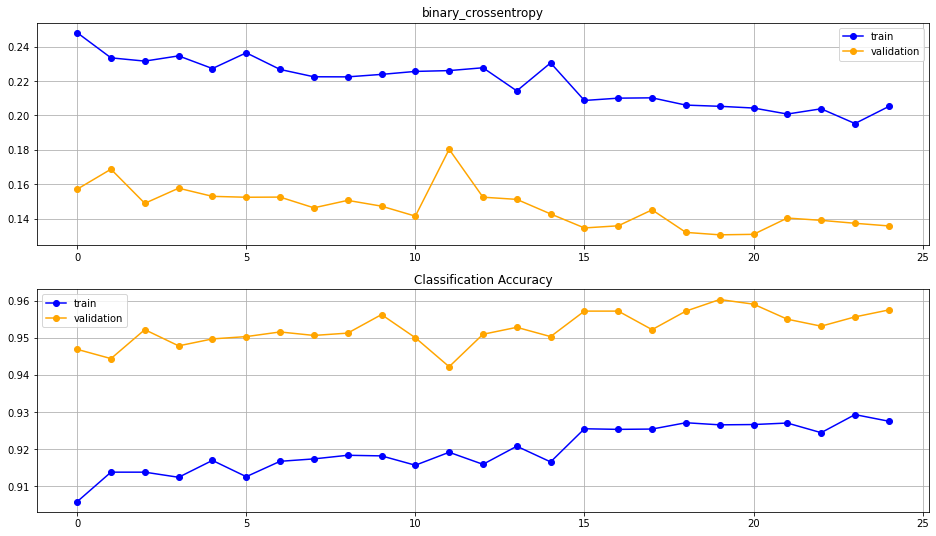

In [166]:
#plot_history(history)

In [167]:
df_metrics, df_confusion_matrix = evaluate_model(model_cnn, X_test, y_test)

,H,S,average_macro
Precion,0.937228,0.969414,0.953321
Recall,0.970500,0.935000,0.952750
F1,0.953574,0.951896,0.952735
Support,2000.000000,2000.000000,-999.000000


,cm_H,cm_S
cm_H,1941,59
cm_S,130,1870


In [168]:
#echo "# Metriques:" > report.md
df_metrics.to_markdown("../report.md", "a")
#echo "   " >> report.md
df_confusion_matrix.to_markdown("../report2.md", "a")

In [169]:
sr_metrics = df_metrics.stack(dropna=False)

In [170]:
sr_confusion_matrix = df_confusion_matrix.stack()

In [171]:
sr_metrics = pd.concat([sr_metrics, sr_confusion_matrix])

In [172]:
mlflow.set_experiment(experiment_name='Projet_A62_neptune')
#mlflow.set_tracking_uri("http://localhost:5000")

In [173]:
with mlflow.start_run(nested=True) as run:
    for idx, val in enumerate(sr_metrics):
        mlflow.log_metric("_".join(sr_metrics.index[idx]) ,val)
    
    mlflow.keras.log_model(model_cnn, "model")
    mlflow.set_tag("model_cnn", str(model_cnn))


INFO:tensorflow:Assets written to: C:\Users\kbenmus\AppData\Local\Temp\tmpplzzecge\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\kbenmus\AppData\Local\Temp\tmpplzzecge\model\data\model\assets


In [174]:
model_cnn.save(PATH_MODEL + "/model_cnn.h5")